In [145]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


In [146]:
import requests

In [147]:
# import urllib3

In [148]:
# http = urllib3.PoolManager()

# Functions

In [149]:
ws_hostname = "127.0.1.1"
ws_hostname = "172.27.0.64"


street_field  = "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "postName"
country_field =  "countryName"
addr_key_field = "referenceKey"

# ws_hostname = "192.168.1.3"

In [150]:

sample_size = None# 1000
def get_addresses(addresses_filename):
    addresses = pd.read_csv(addresses_filename,  
                            usecols = lambda x: x in [addr_key_field, "addr_key",
                                       country_field, 
                                       postcode_field, 
                                       city_field, 
                                       street_field, 
                                       housenbr_field,
                                       country_field], 
                           dtype={postcode_field: str, housenbr_field: str, country_field: str})
    
    
    addresses = addresses.rename(columns={"addr_key": addr_key_field})
    if country_field in addresses: 
        addresses[country_field] =addresses[country_field].fillna("Belgique")
    else: 
        addresses[country_field] = "Belgique"
    #addresses = addresses.rename(columns={"index":addr_key_field})
    
    addresses = addresses[addresses[street_field].notnull() & addresses[city_field].notnull()] # & addresses[country_field].isnull() ]
    
    addresses[postcode_field] = addresses[postcode_field].astype(str)
    
    if sample_size: 
        addresses = addresses.sample(sample_size, random_state=0)
    
    return addresses#.drop(country_field, axis=1)

In [151]:
def call_ws(addr_data, check_result=True, structured_osm=False, with_rejected=False, mode="long", extra_house_number=True): #lg = "en,fr,nl"
    t = datetime.now()
    
    fields = { 
            "checkResult" : check_result,
            "structuredOsm" : structured_osm,
            "withRejected": with_rejected,
            "extraHouseNumber": extra_house_number,
            "mode": mode
        }

    if isinstance(addr_data, pd.Series):
        addr_data = addr_data.to_dict()
        
    data = addr_data#{"address": addr_data    }

        
    try: 
        r = requests.post(
        f'http://{ws_hostname}:5000//REST/nominatimWrapper/v1/geocode',
            params=fields,
            json=data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
#     print(r)
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
#            res = r.text
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [152]:
def split_columns(addresses_batch):
    output = pd.DataFrame(index=addresses_batch.index, dtype=str)

    for f in addresses_batch:
#        print(f)
        grp= addresses_batch[f].apply(lambda r : pd.Series(r, dtype=str) if pd.notnull(r) else pd.Series(dtype=str)) 
        grp = pd.concat({f: grp}, names=['L0', 'L1'], axis=1)
        
        output = pd.concat([output, grp], axis=1)
    # display(output)
    output.columns = pd.MultiIndex.from_tuples(output.columns)
    return output  

In [153]:
def format_ws_res(addresses):
    # assert addresses.json.apply(lambda js: "match" in js).all()
    assert addresses.json.apply(lambda js: len(js["match"])==1 if js is not None and "match" in js else True).all()
    addresses_out = addresses.json.apply(lambda js: pd.Series(js["match"][0]) if js is not None and "match" in js else pd.Series(dtype=object))
    #reject_out = addresses.json.apply(lambda js: pd.Series(js["rejected"][0]) if js is not None and "rejected" in js else pd.Series(dtype=object))
    
    addresses_out =  split_columns(addresses_out)
    return addresses_out

In [154]:
def call_ws_batch(addr_data, mode="coordinates", with_rejected=False, check_result=True, structured_osm=False, extra_house_number=True): #lg = "en,fr,nl"
    #file_data = addr_data.to_csv(index=False)
    
    r = requests.post(
    f'http://{ws_hostname}:5000/REST/nominatimWrapper/v1/batchGeocode',
    params= { 
        'mode': mode,
        "withRejected": with_rejected,
        "checkResult" : check_result,
        "structuredOsm"   : structured_osm,
        "extraHouseNumber": extra_house_number
    },
    json={"addresses": addr_data.fillna('').to_dict(orient="records")}
    )
    
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return None, None
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
        return None, None
    elif r.status_code == 200:
        
        try:

            res_json = json.loads(r.text)
            if "match" in res_json:
                match =  split_columns(pd.DataFrame(res_json["match"]))
                rejected= split_columns(pd.DataFrame(res_json["rejected"])) if "rejected" in res_json and len(res_json["rejected"])>0 else pd.DataFrame()

            else :
                match =  split_columns(pd.DataFrame(res_json))
                rejected=None
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)

            return r.text, None
    
    return match, rejected 
    


# Calls

## Single address calls

In [155]:
res=call_ws({
#         addr_key_field: 5,
        street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=True, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'fast',
    'referenceKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.021287}

In [156]:
res=call_ws({
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
         street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"
}, check_result=True, structured_osm=False, with_rejected=False, mode="long")
res

Argument error
{"message": "Field 'fullAddress' cannot be used together with fields postName;countryName;streetName;postCode;houseNumber"}



In [157]:
res=call_ws({
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
}, check_result=False, structured_osm=False, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'libpostal+regex[lpost]+photon',
    'referenceKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny - Fonsnylaan, 20, 1060 Saint-Gilles - Sint-Gillis, België / Belgique / Belgien',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.360448}

In [158]:
res=call_ws({

    addr_key_field: 5,
    street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=True, structured_osm=True, with_rejected=True, extra_house_number=True)
res

{'match': [{'metadata': {'method': 'orig',
    'referenceKey': '5',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {'simStreetWhich': 'street_name',
    'simStreet': 1.0,
    'simCity': 0.46153846153846156,
    'simPostCode': 1.0,
    'simHouseNumber': 1.0}}],
 'rejected': [{'metadata': {'method': 'orig',
    'referenceKey': '

## Batch calls (row by row)

In [159]:
addresses = pd.concat([
   get_addresses("data/address_restobe.csv.gz").assign(dataset="resto"),
   get_addresses("data/address_best.csv.gz").assign(dataset="best"),
   get_addresses("data/address_cbe.csv.gz").assign(dataset="cbe")
])
addresses = addresses.reset_index(drop=True)
addresses[addr_key_field] = addresses.index.astype(str)
addresses

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4
...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998


In [160]:
# addresses = addresses.sample(100)

In [161]:
# addresses = pd.read_csv("data/address_bad.csv")
# addresses
iter_per_sec_stats={}


### Simple way

In [162]:
# addresses = addresses[addresses.streetName.str.lower().str.contains("steenweg op antwerpen")]

# # addresses = addresses.loc[[100,112,118,142,155,179,198]]
# # addresses = addresses.loc[[ 94,  100,  198, ]]
# addresses = addresses.loc[0:100]
# addresses

In [163]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq.fillna("").progress_apply(call_ws, check_result=False, 
                                                                structured_osm=False, 
                                                                with_rejected=True, 
                                                                mode="short",axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_seq.shape[0]/tot_time
iter_per_sec_stats["sequential"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset:
# Normal mode: 128.78 seconds, 7.77 it/s
# Fastmode:     68.80 seconds, 14.54 it/s

#Resto dataset: 
# Normal mode: 145.73 seconds, 6.86 it/s
# Fast mode:    82.99 seconds, 12.05 it/s

# Best dataset:
# Normal mode: 108.53 seconds, 9.21 it/s
# Fast mode: 37.44 seconds, 26.71 it/s

addresses_seq

  0%|          | 0/3000 [00:00<?, ?it/s]

No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}

149.86 seconds, 20.02 it/s


,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey,json
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0,"{'match': [{'metadata': {'method': 'fast', 're..."
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1,"{'match': [{'metadata': {'method': 'fast', 're..."
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2,"{'match': [{'metadata': {'method': 'fast', 're..."
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3,"{'match': [{'metadata': {'method': 'fast', 're..."
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4,"{'match': [{'metadata': {'method': 'fast', 're..."
...,...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995,{'match': [{'metadata': {'method': 'regex[init...
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996,"{'match': [{'metadata': {'method': 'fast', 're..."
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997,"{'match': [{'metadata': {'method': 'fast', 're..."
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998,"{'match': [{'metadata': {'method': 'fast', 're..."


In [164]:
timing = addresses_seq[["dataset"]].copy()
timing["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
timing["method"] =addresses_seq.json.apply(lambda j: j["match"][0]["metadata"]["method"] if j else None) 

timing

,dataset,time,method
0,resto,0.027892,fast
1,resto,0.029889,fast
2,resto,0.020634,fast
3,resto,0.046356,fast
4,resto,0.020417,fast
...,...,...,...
2995,cbe,0.128979,regex[init]
2996,cbe,0.067287,fast
2997,cbe,0.048152,fast
2998,cbe,0.030103,fast


<AxesSubplot:title={'center':'Avg call duration'}, xlabel='dataset'>

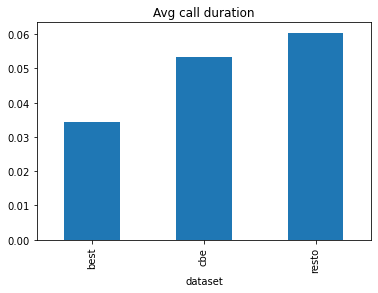

In [165]:
(timing.groupby("dataset").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:title={'center':'Avg call duration'}, xlabel='method'>

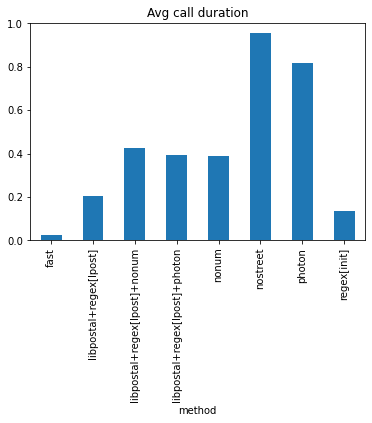

In [166]:
(timing.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:xlabel='dataset'>

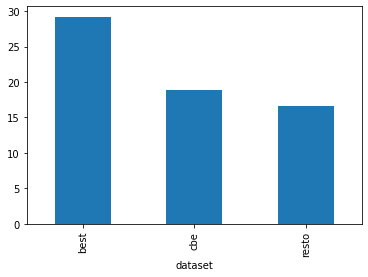

In [167]:
(1/timing.groupby("dataset").time.mean()).plot.bar("Iterations per seconds")

dataset
best     AxesSubplot(0.125,0.125;0.775x0.755)
cbe      AxesSubplot(0.125,0.125;0.775x0.755)
resto    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

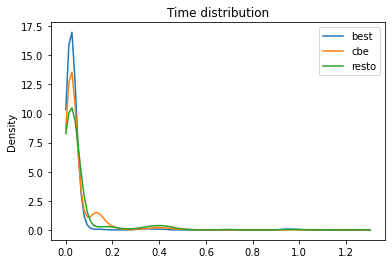

In [168]:
timing.groupby("dataset").time.plot.kde(legend=True, ind=np.linspace(0,timing.time.max(), 100 ), title="Time distribution" )

method
fast                             AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]           AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+nonum     AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+photon    AxesSubplot(0.125,0.125;0.775x0.755)
nonum                            AxesSubplot(0.125,0.125;0.775x0.755)
nostreet                         AxesSubplot(0.125,0.125;0.775x0.755)
regex[init]                      AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

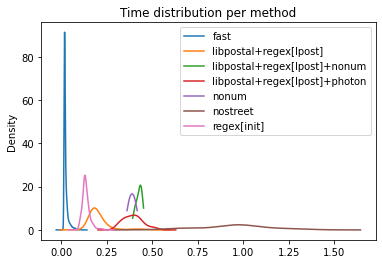

In [169]:
mthd_vc= timing.method.value_counts()
mthd_vc[mthd_vc==1]
timing[~timing.method.isin(mthd_vc[mthd_vc==1].index)][["method", "time"]].groupby("method").time.plot.kde(legend=True, title="Time distribution per method" )

<AxesSubplot:title={'center':'time'}, xlabel='[dataset]'>

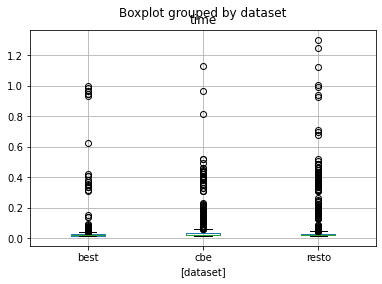

In [170]:
timing[["time", "dataset"]].boxplot(by="dataset")#.boxplot()

<AxesSubplot:title={'center':'Iterations per second'}>

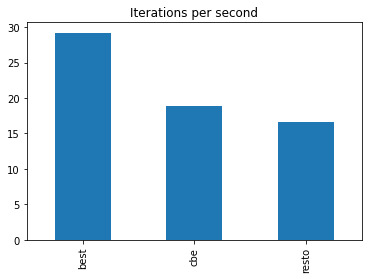

In [171]:
(timing.dataset.value_counts()/timing.groupby("dataset").time.sum()).plot.bar(title="Iterations per second")

In [172]:
addresses_seq_out = format_ws_res(addresses_seq)
addresses_seq_out

metadata                         \
           method referenceKey placeRank   
0            fast            0        30   
1            fast            1        26   
2            fast            2        30   
3            fast            3        26   
4            fast            4        30   
...           ...          ...       ...   
2995  regex[init]         2995        30   
2996         fast         2996        26   
2997         fast         2997        26   
2998         fast         2998        26   
2999         fast         2999        30   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2995                              Rue du Wainage          62     5060   
2996                         Chaussée de Tournai         NaN     7520   
2997                              Rue Louis Caty         NaN     7331   
2998                          Drève des Bouleaux         NaN     7090   
2999                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2995      Sambreville  België / Belgique / Belgien   
2996   Ramegnies-Chin  België / Belgique / Belgien   
2997   Saint-Ghislain  België / Belgique / Belgien   
2998  Braine-le-Comte  België / Belgique / Belgien   
2999              Spa  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...          ['198', '']   
1     Rue de la Halle, Namur, Wallonie, 5000, België...           ['11', '']   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...           ['38', '']   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...          ['200', '']   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...            ['9', '']   
...                                                 ...                  ...   
2995  62, Rue du Wainage, Keumiée, Sambreville, Namu...           ['62', '']   
2996  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...            ['4', '']   
2997  Rue Louis Caty, Quartier de la Charbonnière, B...           ['32', '']   
2998  Drève des Bouleaux, Coraimont, Braine-le-Comte...            ['5', '']   
2999  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...            ['1', '']   

                                                               
                     lat                 lon            other  
0             50.5556305   4.907401297756147              NaN  
1             50.4627801           4.8655064              NaN  
2     50.868676699999995   4.321060219298245              NaN  
3             50.4161219           6.1119552              NaN  
4             51.0399911           4.8089699              NaN  
...                  ...                 ...              ...  
2995           50.462361  4.5964580703527815  Namur - Keumiée  
2996          50.6394448           3.3490581              NaN  
2997          50.4797372           3.8389755              NaN  
2998          50.6063976           4.1

In [173]:
# addresses_seq_out[addresses_seq_out[("output", "lat")].isnull()]

In [174]:
# rejected_seq_out = format_ws_res(rejected)
# rejected_seq_out

rejected = addresses_seq.json.apply(lambda js: pd.Series(js["rejected"]) if js is not None and "rejected" in js and len(js["rejected"])>0 else pd.Series(dtype=object))
rejected = rejected.unstack().dropna()
rejected = split_columns(rejected.apply(pd.Series))
rejected

metadata                                      \
                        method referenceKey placeRank rejectReason   
0  4                      fast            4        30         tail   
   9                      fast            9        26         tail   
   13                     fast           13        26         tail   
   15                     fast           15        30         tail   
   22                     fast           22        26         tail   
...                        ...          ...       ...          ...   
46 443  libpostal+regex[lpost]          443      30.0         tail   
47 94   libpostal+regex[lpost]           94      30.0         tail   
   443  libpostal+regex[lpost]          443      30.0         tail   
48 94   libpostal+regex[lpost]           94      30.0         tail   
   443  libpostal+regex[lpost]          443      30.0         tail   

                                                      output              \
       distanceToMatch                            streetName houseNumber   
0  4             0.021                    Kleine Waterstraat           9   
   9             0.055          Place Jourdan - Jourdanplein         NaN   
   13            0.108                    Rue des Charmilles         NaN   
   15            0.011                     Chaussée de Liège        1178   
   22            0.053                           Place Verte         NaN   
...                ...                                   ...         ...   
46 443            0.61              Rue du Midi - Zuidstraat           8   
47 94           15.553                              Wipplein         7;8   
   443             0.4  Rue des Hirondelles - Zwaluwenstraat           8   
48 94           11.252                      Lijsterbolstraat        7;7A   
   443           0.585    Boulevard d'Anvers - Antwerpselaan           8   

                                                                   \
       postCode             postName                  countryName   
0  4       2235             Hulshout  België / Belgique / Belgien   
   9       1040            Etterbeek  België / Belgique / Belgien   
   13      4960              Malmedy  België / Belgique / Belgien   
   15      5101      Lives-sur-Meuse  België / Belgique / Belgien   
   22      4800             Verviers  België / Belgique / Belgien   
...         ...                  ...                          ...   
46 443     1000  Bruxelles - Brussel  België / Belgique / Belgien   
47 94      2850                 Boom  België / Belgique / Belgien   
   443     1000  Bruxelles - Brussel  België / Belgique / Belgien   
48 94      2550              Kontich  België / Belgique / Belgien   
   443     1000  Bruxelles - Brussel  België / Belgique / Belgien   

                                                                               \
                                              displayName                 lat   
0  4    9, Kleine Waterstraat, Houtvenne, Hulshout, Tu...         51.03990125   
   9    Place Jourdan - Jourdanplein, Etterbeek, Bruss...          50.8375788   
   13   Rue des Charmilles, Xhoffraix, Malmedy, Vervie...          50.4610681   
   15   New Hotel de Lives-sur-meuse, 1178, Chaussée d...          50.4780918   
   22   Place Verte, Ensival, Verviers, Liège, Walloni...           50.592586   
...                                                   ...                 ...   
46 443  8, Rue du Midi - Zuidstraat, Quartier du Centr...           50.847404   
47 94   7;8, Wipplein, Boom, Antwerpen, Vlaanderen, 28...         51.08806985   
   443  8, Rue des Hirondelles - Zwaluwenstraat, Quart...          50.8522407   
48 94   7;7A, Lijsterbolstraat, Kontich, Antwerpen, Vl...         51.12933245   
   443  8, Boulevard d'Anvers - Antwerpselaan, Bruxell...  50.856144549999996   

                                                                               
                       lon                                              other  
0  4     4

In [175]:
addresses_seq_out[addresses_seq_out[("metadata", "referenceKey")] == "443"]

metadata                         \
                     method referenceKey placeRank   
443  libpostal+regex[lpost]          443        30   

                               output                       \
                           streetName houseNumber postCode   
443  Rue du Persil - Peterseliestraat           8     1000   

                                                       \
                postName                  countryName   
443  Bruxelles - Brussel  België / Belgique / Belgien   

                                                                             \
                                           displayName libpostalHouseNumber   
443  Les Amis Philanthropes nº 3, 8, Rue du Persil ...         ['8-10', '']   

                                                                              
           lat        lon                                              other  
443  50.851256  4.3572509  Brussel-Hoofdstad - Bruxelles-Capitale - Les A...

In [176]:
# addresses_seq_out[addresses_seq_out[("metadata", "retryOn26")] =="True"]

In [177]:
addresses_seq_out[("metadata", "method")].value_counts(dropna=False)

fast                             2725
regex[init]                       113
libpostal+regex[lpost]+photon      90
libpostal+regex[lpost]             46
nostreet                           19
libpostal+regex[lpost]+nonum        3
nonum                               2
NaN                                 1
photon                              1
Name: (metadata, method), dtype: int64

In [178]:
# addresses_seq_out[addresses_seq_out[("work", 0)].isnull()]
addresses_seq_out[addresses_seq_out[("metadata", "method")] != "fast"]

metadata                         \
                             method referenceKey placeRank   
10    libpostal+regex[lpost]+photon           10        26   
32                         nostreet           32        20   
33    libpostal+regex[lpost]+photon           33        30   
36           libpostal+regex[lpost]           36        30   
37    libpostal+regex[lpost]+photon           37        26   
...                             ...          ...       ...   
2974                    regex[init]         2974        30   
2977         libpostal+regex[lpost]         2977        30   
2980                    regex[init]         2980        26   
2987         libpostal+regex[lpost]         2987        30   
2995                    regex[init]         2995        30   

                   output                                          \
               streetName houseNumber postCode           postName   
10      Avenue Albert Ier         NaN     4607             Feneur   
32       Klein-Willebroek         NaN     2850         Willebroek   
33      Rue du Roi Albert           4     4102            Seraing   
36       Rue Hors-Château     25 - 27     4000              Liège   
37      Allée des Érables         NaN     4000              Liège   
...                   ...         ...      ...                ...   
2974           Hoogstraat          13     9450           Haaltert   
2977  Twaalfmaandenstraat          17     2000          Antwerpen   
2980   Rue de Quevaucamps         NaN     7971           Basècles   
2987         Rue des Prés           9     6900  Marche-en-Famenne   
2995       Rue du Wainage          62     5060        Sambreville   

                                   \
                      countryName   
10    België / Belgique / Belgien   
32    België / Belgique / Belgien   
33    België / Belgique / Belgien   
36    België / Belgique / Belgien   
37    België / Belgique / Belgien   
...                           ...   
2974  België / Belgique / Belgien   
2977  België / Belgique / Belgien   
2980  België / Belgique / Belgien   
2987  België / Belgique / Belgien   
2995  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
10    Avenue Albert Ier, Feneur, Dalhem, Liège, Wall...           ['14', '']   
32    Klein-Willebroek, Willebroek, Mechelen, Antwer...           ['10', '']   
33    4, Rue du Roi Albert, Ougrée, Seraing, Liège, ...            ['4', '']   
36    Église Notre-Dame-de-l'Immaculée-Conception, 2...      ['27c;27c', '']   
37    Allée des Érables, Liège, Wallonie, 4000, Belg...             ['', '']   
...                                                 ...                  ...   
2974  13, Hoogstraat, Haaltert, Aalst, Oost-Vlaander...           ['13', '']   
2977  17, Twaalfmaandenstraat, Wilde Zee, Antwerpen,...           ['17', '']   
2980  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...           ['19', '']   
2987  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...            ['9', '']   
2995  62, Rue du Wainage, Keumiée, Sambreville, Namu...           ['62', '']   

                                              \
                     lat                 lon   
10             50.709418           5.7212279   
32            51.0809815           4.3664578   
33            50.5999714   5.534529605620154   
36    50.647537549999996   5.578972173776486   
37            50.5772727           5.5937698   
...                  ...                 ...   
2974          50.9008776   4.005555559299696   
2977         51.21859445   4.406012982607047   
2980          50.5227341           3.6611157   
2987  50.202871349999995   5.316060794052932   
2995           50.462361  4.5964580703527815   

                                                         
                                                  other  
10                                                Liège  


In [179]:
# call_ws(addresses_seq.loc[700], check_result=False, with_rejected=False)

In [180]:
# call_ws(addresses_seq.loc[4], check_result=False, with_rejected=True)

In [181]:
# addresses_seq_out[addresses_seq.json.apply(lambda js: "osmOrder" in js["match"][0]['work'] if js else None).fillna(False)]

In [182]:
addresses_seq

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey,json
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0,"{'match': [{'metadata': {'method': 'fast', 're..."
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1,"{'match': [{'metadata': {'method': 'fast', 're..."
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2,"{'match': [{'metadata': {'method': 'fast', 're..."
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3,"{'match': [{'metadata': {'method': 'fast', 're..."
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4,"{'match': [{'metadata': {'method': 'fast', 're..."
...,...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995,{'match': [{'metadata': {'method': 'regex[init...
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996,"{'match': [{'metadata': {'method': 'fast', 're..."
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997,"{'match': [{'metadata': {'method': 'fast', 're..."
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998,"{'match': [{'metadata': {'method': 'fast', 're..."


### Using Dask

In [183]:
addresses_dask = addresses.copy()

In [184]:
addresses_dask

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4
...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998


In [185]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=8)

dask_task = dd_addresses.apply(call_ws, check_result=False, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["dask"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO dataset:
# Normal mode: 24.52 seconds, 40.79 it/s
# Fastmode:    15.81 seconds, 63.27 it/s


# Resto dataset:
# Normal mode: 27.86 seconds, 35.89 it/s
# Fast mode:   18.44 seconds, 54.23 it/s

# Best dataset: 
# Normal mode: 16.11 seconds, 62.07 it/s
# Fast mode:    9.76 seconds, 102.42 it/s

[                                        ] | 0% Completed |  4.9sNo result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}

[########################################] | 100% Completed | 30.9s
30.96 seconds, 96.90 it/s


In [186]:
# 1000, 1 worker: 4m18
# 4 workers, npart=4 : 1m20
# 8 workers, npart=4 : 1m20
# 8 workers, npart=8 : 44s

# with checker=False:
# 8 workers, npart=8 : 24s


In [187]:
# expand_json(addresses_dask)

addresses_dask_out = format_ws_res(addresses_dask)
addresses_dask_out

metadata                                  \
           method referenceKey placeRank  placeId   
0            fast            0        30  2580480   
1            fast            1        26   392307   
2            fast            2        30  1094419   
3            fast            3        26   342040   
4            fast            4        30   171744   
...           ...          ...       ...      ...   
2995  regex[init]         2995        30  2657266   
2996         fast         2996        26  1983533   
2997         fast         2997        26   432987   
2998         fast         2998        26   379561   
2999         fast         2999        30  1868481   

                                                                  \
                                     transformedAddress osmOrder   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique        0   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique        0   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...        0   
3             rue du Centre, 200, 4950 WAIMES, Belgique        0   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique        0   
...                                                 ...      ...   
2995     Rue du Wainage, 62, 5060 Sambreville, Belgique        0   
2996  Chaussée de Tournai(R-C), 4, 7520 Tournai, Bel...        0   
2997  Rue Louis Caty(B), 32, 7331 Saint-Ghislain, Be...        0   
2998  Drève des Bouleaux, 5, 7090 Braine-le-Comte, B...        0   
2999                  Rue Rogier, 1, 4900 Spa, Belgique        0   

                                                     \
     matchOnCleansedHouseNumber cleansedHouseNumber   
0                           NaN                 NaN   
1                           NaN                 NaN   
2                           NaN                 NaN   
3                           NaN                 NaN   
4                           NaN                 NaN   
...                         ...                 ...   
2995                        NaN                 NaN   
2996                        NaN                 NaN   
2997                        NaN                 NaN   
2998                        NaN                 NaN   
2999                        NaN                 NaN   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2995                              Rue du Wainage          62     5060   
2996                         Chaussée de Tournai         NaN     7520   
2997                              Rue Louis Caty         NaN     7331   
2998                          Drève des Bouleaux         NaN     7090   
2999                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2995      Sambreville  België / Belgique / Belgien   
2996   Ramegnies-Chin  België / Belgique / Belgien   
2997   Saint-Ghislain  België / Belgique / Belgien   
2998  Braine-le-Comte  België / Belgique / Belgien   
2999              Spa  België / Belgique / Belgien   

                                                                 

In [188]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].merge(
    addresses_dask_out[fields], how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_62252/615264633.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].merge(


In [189]:
mg

metadata                        output           \
     referenceKey       method         postName postCode   
0               0         fast            Leuze     5310   
1               1         fast            Namur     5000   
2               2         fast        Ganshoren     1083   
3               3         fast           Waimes     4950   
4               4         fast         Hulshout     2235   
...           ...          ...              ...      ...   
2995         2995  regex[init]      Sambreville     5060   
2996         2996         fast   Ramegnies-Chin     7520   
2997         2997         fast   Saint-Ghislain     7331   
2998         2998         fast  Braine-le-Comte     7090   
2999         2999         fast              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2995                              Rue du Wainage          62   both  
2996                         Chaussée de Tournai         NaN   both  
2997                              Rue Louis Caty         NaN   both  
2998                          Drève des Bouleaux         NaN   both  
2999                                  Rue Rogier           1   both  

[3000 rows x 7 columns]

## Batch calls (batch WS)

### Single block

In [190]:
# addresses=addresses[addresses.addrKey.isin(["1075", "1331", "2616"])]
# addresses=addresses[addresses.addrKey.isin(["2206", "2556", "2569", "2715"])]
# addresses=addresses.iloc[0:10]
addresses


,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4
...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998


In [191]:
t = datetime.now()

addresses_batch, rejected = call_ws_batch(addresses[[addr_key_field, 
                                           street_field, housenbr_field, postcode_field, city_field, country_field]], 
                                mode="short", 
                                check_result=False, 
                                structured_osm=False,
                                with_rejected=False)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses.shape[0]/tot_time
iter_per_sec_stats["batch_single_bloc"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset: 33.94 seconds, 29.46 it/s
# Best:        24.99 seconds, 40.01 it/s
# Resto:       38.33 seconds, 26.09 it/s

addresses_batch

87.66 seconds, 34.23 it/s


metadata                                  \
           method referenceKey placeRank  placeId   
0            orig            0        30  2580480   
1            orig            1        26   392307   
2            orig            2        30  1094419   
3            orig            3        26   342040   
4            orig            4        30   171744   
...           ...          ...       ...      ...   
2994  regex[init]         2995        30  2657266   
2995         orig         2996        26  1983533   
2996         orig         2997        26   432987   
2997         orig         2998        26   379561   
2998         orig         2999        30  1868481   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2994                              Rue du Wainage          62     5060   
2995                         Chaussée de Tournai         NaN     7520   
2996                              Rue Louis Caty         NaN     7331   
2997                          Drève des Bouleaux         NaN     7090   
2998                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2994      Sambreville  België / Belgique / Belgien   
2995   Ramegnies-Chin  België / Belgique / Belgien   
2996   Saint-Ghislain  België / Belgique / Belgien   
2997  Braine-le-Comte  België / Belgique / Belgien   
2998              Spa  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...   
...                                                 ...   
2994  62, Rue du Wainage, Keumiée, Sambreville, Namu...   
2995  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...   
2996  Rue Louis Caty, Quartier de la Charbonnière, B...   
2997  Drève des Bouleaux, Coraimont, Braine-le-Comte...   
2998  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...   

                                                                              \
                                                  other libpostalHouseNumber   
0                                       Namur - Éghezée          ['198', '']   
1                                                   NaN           ['11', '']   
2                Brussel-Hoofdstad - Bruxelles-Capitale           ['38', '']   
3                                      Liège - Verviers          ['200', '']   
4     Antwerpen - Tennisclub Lybo - Houtvenne - Turn...            ['9', '']   
...                                                 ...                  ...   
2994                                    Keumiée - Namur           ['62', '']   
2995     Tournai-Mouscron - Tournai - Hurette - Hainaut            ['4', '']   
2996  Mons - Quartier de la Charbonnière - Baudour -...           ['32', '']   
2997              

In [192]:
addresses_batch[("check", "SIMStreetWhich")].value_counts() if ("check", "SIMStreetWhich") in addresses_batch else None

In [193]:
addresses_batch[ addresses_batch[("check", "SIMStreetWhich")] != "street_name"] if ("check", "SIMStreetWhich") in addresses_batch else None

In [194]:
addresses_batch[("metadata", "method")].value_counts()

orig                             2725
regex[init]                       113
libpostal+regex[lpost]+photon      90
libpostal+regex[lpost]             46
nostreet                           19
libpostal+regex[lpost]+nonum        3
nonum                               2
photon                              1
Name: (metadata, method), dtype: int64

In [195]:
rejected

""


In [196]:
fields

[('metadata', 'referenceKey'),
 ('metadata', 'method'),
 ('output', 'postName'),
 ('output', 'postCode'),
 ('output', 'streetName'),
 ('output', 'houseNumber')]

In [197]:
# addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
#     addresses_batch[fields], how="outer", indicator=True)
# addresses_batch[fields]

In [198]:
# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch[fields], how="outer", indicator=True)

if mg[mg._merge == "both"].shape[0] == addresses_batch.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_62252/748407910.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


In [199]:
mg

metadata                        output           \
     referenceKey       method         postName postCode   
0               0         orig            Leuze     5310   
1               1         orig            Namur     5000   
2               2         orig        Ganshoren     1083   
3               3         orig           Waimes     4950   
4               4         orig         Hulshout     2235   
...           ...          ...              ...      ...   
2994         2995  regex[init]      Sambreville     5060   
2995         2996         orig   Ramegnies-Chin     7520   
2996         2997         orig   Saint-Ghislain     7331   
2997         2998         orig  Braine-le-Comte     7090   
2998         2999         orig              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2994                              Rue du Wainage          62   both  
2995                         Chaussée de Tournai         NaN   both  
2996                              Rue Louis Caty         NaN   both  
2997                          Drève des Bouleaux         NaN   both  
2998                                  Rue Rogier           1   both  

[2999 rows x 7 columns]

In [200]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="coordinates", 
                           check_result=True, 
                           with_rejected=True) 
match

metadata                                     output                    
        method referenceKey placeRank                 lat                 lon
0         orig            0        30          50.5556305   4.907401297756147
1         orig            1        26          50.4627801           4.8655064
2         orig         1000        26          50.9566699           3.6415525
3         orig         1001        30         50.91119645  4.7150743897059115
4         orig         1002        30          50.8265812   4.302949641747071
...        ...          ...       ...                 ...                 ...
2994  nostreet          669        21   51.21132184441221    4.32753532032106
2995  nostreet          682        14          50.4265348           6.0276059
2996  nostreet          758        21    50.1556859003716   5.203150031937894
2997  nostreet           93        19          50.3416114            4.838456
2998  nostreet           94        21  51.274763050000004   4.357808558108607

[2999 rows x 5 columns]

In [201]:
# rej[rej[("metadata", "rejectReason")]!="tail"]

In [202]:
# rej[rej.duplicated(keep=False)]

In [203]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="short", 
                           check_result=False) 
match


metadata                                  \
           method referenceKey placeRank  placeId   
0            orig            0        30  2580480   
1            orig            1        26   392307   
2            orig            2        30  1094419   
3            orig            3        26   342040   
4            orig            4        30   171744   
...           ...          ...       ...      ...   
2994  regex[init]         2995        30  2657266   
2995         orig         2996        26  1983533   
2996         orig         2997        26   432987   
2997         orig         2998        26   379561   
2998         orig         2999        30  1868481   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2994                              Rue du Wainage          62     5060   
2995                         Chaussée de Tournai         NaN     7520   
2996                              Rue Louis Caty         NaN     7331   
2997                          Drève des Bouleaux         NaN     7090   
2998                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2994      Sambreville  België / Belgique / Belgien   
2995   Ramegnies-Chin  België / Belgique / Belgien   
2996   Saint-Ghislain  België / Belgique / Belgien   
2997  Braine-le-Comte  België / Belgique / Belgien   
2998              Spa  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...   
...                                                 ...   
2994  62, Rue du Wainage, Keumiée, Sambreville, Namu...   
2995  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...   
2996  Rue Louis Caty, Quartier de la Charbonnière, B...   
2997  Drève des Bouleaux, Coraimont, Braine-le-Comte...   
2998  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...   

                                                                              \
                                                  other libpostalHouseNumber   
0                                       Namur - Éghezée          ['198', '']   
1                                                   NaN           ['11', '']   
2                Brussel-Hoofdstad - Bruxelles-Capitale           ['38', '']   
3                                      Liège - Verviers          ['200', '']   
4     Antwerpen - Tennisclub Lybo - Houtvenne - Turn...            ['9', '']   
...                                                 ...                  ...   
2994                                    Keumiée - Namur           ['62', '']   
2995     Tournai-Mouscron - Tournai - Hurette - Hainaut            ['4', '']   
2996  Mons - Quartier de la Charbonnière - Baudour -...           ['32', '']   
2997              

In [204]:
rej

""


In [205]:
# Geocode + address, with rejected addresses
match, rej = call_ws_batch(addresses, mode="long", with_rejected=True)
match

metadata                                  \
        method referenceKey placeRank  placeId   
0         orig            0        30  2580480   
1         orig            1        26   392307   
2         orig         1000        26   945686   
3         orig         1001        30  1107156   
4         orig         1002        30  1030137   
...        ...          ...       ...      ...   
2994  nostreet          669        21  4004242   
2995  nostreet          682        14  3934860   
2996  nostreet          758        21  4004734   
2997  nostreet           93        19   102030   
2998  nostreet           94        21  3994333   

                                                                  \
                                     transformedAddress osmOrder   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique        0   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique        0   
2                Steenweg, 269, 9810 Nazareth, Belgique        0   
3              Centrumstraat, 5, 3012 Louvain, Belgique        0   
4     Rue Félix De Cuyper, 39, 1070 Anderlecht, Belg...        0   
...                                                 ...      ...   
2994                         2070 ZWIJNDRECHT, Belgique        0   
2995                             4950 MALMEDY, Belgique        0   
2996                           5580 ROCHEFORT, Belgique        0   
2997                   5537 ANNEVOIE-ROUILLON, Belgique        0   
2998                              2030 ANVERS, Belgique        0   

                                           output                       \
                                       streetName houseNumber postCode   
0                               Chaussée de Namur         198     5310   
1                                 Rue de la Halle         NaN     5000   
2                                        Steenweg         NaN     9810   
3                                   Centrumstraat           5     3012   
4     Rue Félix De Cuyper - Félix De Cuyperstraat          39     1070   
...                                           ...         ...      ...   
2994                                          NaN         NaN     2070   
2995                                          NaN         NaN     4960   
2996                                          NaN         NaN     5580   
2997                                          NaN         NaN     5537   
2998                                          NaN         NaN     2030   

                         ...  \
               postName  ...   
0                 Leuze  ...   
1                 Namur  ...   
2                   Eke  ...   
3               Wilsele  ...   
4            Anderlecht  ...   
...                 ...  ...   
2994        Zwijndrecht  ...   
2995            Malmedy  ...   
2996          Rochefort  ...   
2997  Annevoie-Rouillon  ...   
2998                NaN  ...   

                                                         \
                                            displayName   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   
2     Steenweg, Eke, Nazareth, Gent, Oost-Vlaanderen...   
3     5, Centrumstraat, Wilsele, Leuven, Vlaams-Brab...   
4     39, Rue Félix De Cuyper - Félix De Cuyperstraa...   
...                                                 ...   
2994  Zwijndrecht, Antwerpen, Vlaanderen, 2070, Belg...   
2995  Malmedy, Verviers, Liège, Wallonie, 4960, Belg...   
2996  Rochefort, Dinant, Namur, Wallonie, 5580, Belg...   
2997  Annevoie-Rouillon, Anhée, Dinant, Namur, Wallo...   
2998  Antwerpen, Vlaanderen, 2030, België / Belgique...   

                                                                              \
                                                  other libpostalHouseNumber   
0                                       Namur - Éghezée          ['198', '']   
1                                                   NaN           ['11', '']   
2 

In [206]:
rej

metadata                                                               \
        method referenceKey placeRank  placeId rejectReason distanceToMatch   
0         orig           93        30  2559050     mismatch           0.815   
1         orig          229        26   464301     mismatch           2.299   
2         orig          292        30  1202464     mismatch           1.557   
3         orig          785        30  1795841     mismatch           5.407   
4         orig          797        30  1277066     mismatch           2.646   
...        ...          ...       ...      ...          ...             ...   
1171  nostreet          198        21  4004235         tail           0.114   
1172  nostreet          337        21  4004235         tail           0.114   
1173  nostreet          473        21  4004236         tail           0.326   
1174  nostreet          602        21  4004236         tail           0.326   
1175  nostreet           94        21  4004238         tail           3.835   

                                                                  \
                                     transformedAddress osmOrder   
0     route des Jardins, 35, 5537 ANNEVOIE-ROUILLON,...        0   
1                Jardon, 46-48, 4800 VERVIERS, Belgique        3   
2     Place Wiener, 4, 1170 WATERMAEL-BOITSFORT, Bel...        2   
3                      Dorp, 29, 2980 ZOERSEL, Belgique        2   
4            Rue du Collège, 33, 4600 BERNEAU, Belgique        0   
...                                                 ...      ...   
1171                       2000 ANVERS-CENTRE, Belgique        1   
1172                       2000 ANVERS-CENTRE, Belgique        1   
1173                              2018 ANVERS, Belgique        1   
1174                              2018 ANVERS, Belgique        1   
1175                              2030 ANVERS, Belgique        1   

                                          output              ...  \
                                      streetName houseNumber  ...   
0                     Rue des Jardins d'Annevoie          35  ...   
1                           Avenue Julien Jardon         NaN  ...   
2     Avenue Léopold Wiener - Léopold Wienerlaan           4  ...   
3                                     Halle-Dorp          29  ...   
4                                 Rue de Battice          33  ...   
...                                          ...         ...  ...   
1171                                         NaN         NaN  ...   
1172                                         NaN         NaN  ...   
1173                                         NaN         NaN  ...   
1174                                         NaN         NaN  ...   
1175                                         NaN         NaN  ...   

                                   \
                      countryName   
0     België / Belgique / Belgien   
1     België / Belgique / Belgien   
2     België / Belgique / Belgien   
3     België / Belgique / Belgien   
4     België / Belgique / Belgien   
...                           ...   
1171  België / Belgique / Belgien   
1172  België / Belgique / Belgien   
1173  België / Belgique / Belgien   
1174  België / Belgique / Belgien   
1175  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     35, Rue des Jardins d'Annevoie, Rouillon, Anhé...   
1     Avenue Julien Jardon, Mangombroux, Stembert, V...   
2     4, Avenue Léopold Wiener - Léopold Wienerlaan,...   
3     29, Halle-Dorp, Halle, Zoersel, Antwerpen, Vla...   
4     33, Rue de Battice, Berneau, Dalhem, Liège, Wa...   
...                                                 ...   
1171  Antwerpen, Vlaanderen, 2000, België / Belgique...   
1172  Antwerpen, Vlaanderen, 2000, België / Belgique...   
1173  Antwerpen, Vlaanderen, 2018, België / Belgique...   
1174  Antwerpen, Vlaanderen, 2018, België / Belgique...   
1175 

### Batch blocs

In [207]:
# addresses = addresses.sample(10000, replace=True)
# addresses = addresses.reset_index(drop=True)
# addresses["addr_key"]= addresses.index.astype(str)

In [208]:
t = datetime.now()

nb_threads=8

chunks = np.array_split(addresses, nb_threads) # addresses.shape[0]//100)

print(f"{len(chunks)} chunks on {nb_threads} threads")

import multiprocess as mp

p = mp.Pool(nb_threads)

def f(chunk):
    return call_ws_batch(chunk, mode="short", 
                        check_result=False, 
                        structured_osm=False)[0]

with p:
     res= list(tqdm(p.imap(f, chunks), total=len(chunks)))
    
addresses_batch2 = pd.concat(res).reset_index(drop=True)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["batch_parallel_blocs"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO:    9.28 seconds, 107.72 it/s
# Best:   6.88 seconds, 145.43 it/s
# Resto: 11.79 seconds,  84.85 it/s

8 chunks on 8 threads


  0%|          | 0/8 [00:00<?, ?it/s]

21.10 seconds, 142.21 it/s


In [209]:
# addresses_batch2
# expand_batch_address(addresses_batch2)

In [210]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch2[fields], how="outer", indicator=True)


# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch2[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

if mg[mg._merge == "both"].shape[0] == addresses_batch2.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_62252/579610436.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


<AxesSubplot:title={'center':'Iterations per second'}>

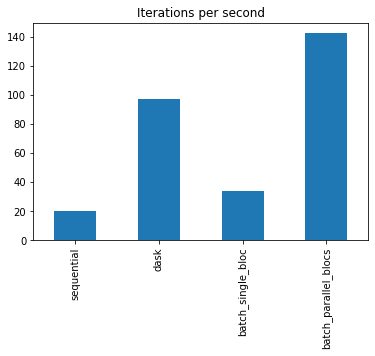

In [211]:
# pd.DataFrame(
pd.Series(iter_per_sec_stats).plot.bar(title='Iterations per second')

## Comparing options

In [212]:
if addresses.shape[0] > 500:
    addresses = addresses.sample(500)

In [213]:
# Single call
results = {}
it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    results[(mode,  check_label, struct_label, extra_hn)] =  addresses.fillna("").apply(call_ws, 
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode,axis=1)

    it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(it_per_seconds))
print("Iterations per seconds (single calls):")
it_per_seconds = pd.DataFrame(it_per_seconds)
it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652


coordinates check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123


coordinates check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000


coordinates nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797


coordinates nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


short nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


long nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


Iterations per seconds (single calls):


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.164493
1,coordinates,check,struct,noextrahn,5.309652
2,coordinates,check,unstruct,extrahn,5.145123
3,coordinates,check,unstruct,noextrahn,5.375892
4,coordinates,nocheck,struct,extrahn,25.160449
5,coordinates,nocheck,struct,noextrahn,27.907000
6,coordinates,nocheck,unstruct,extrahn,23.316797
7,coordinates,nocheck,unstruct,noextrahn,25.090308
8,short,check,struct,extrahn,5.329589
9,short,check,struct,noextrahn,5.487285


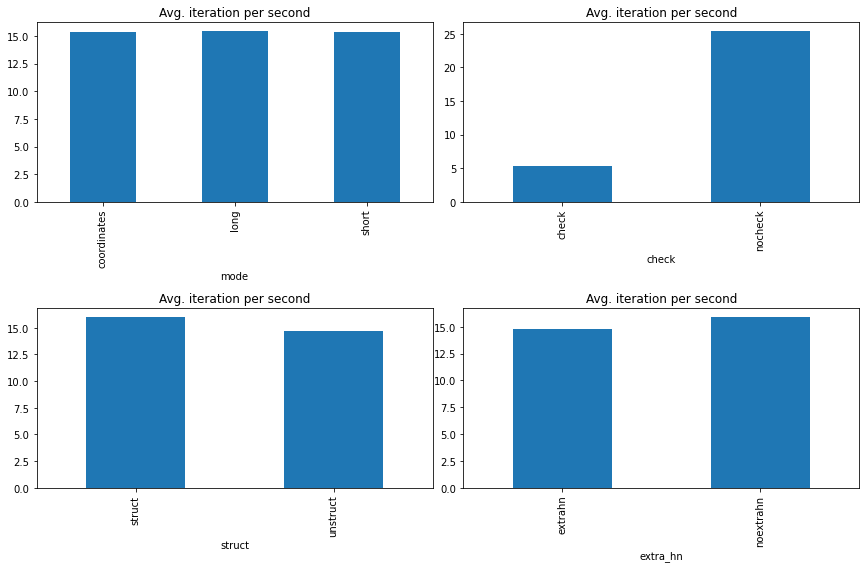

In [214]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second", ax=fl_ax[i])
plt.tight_layout()
#     plt.show()

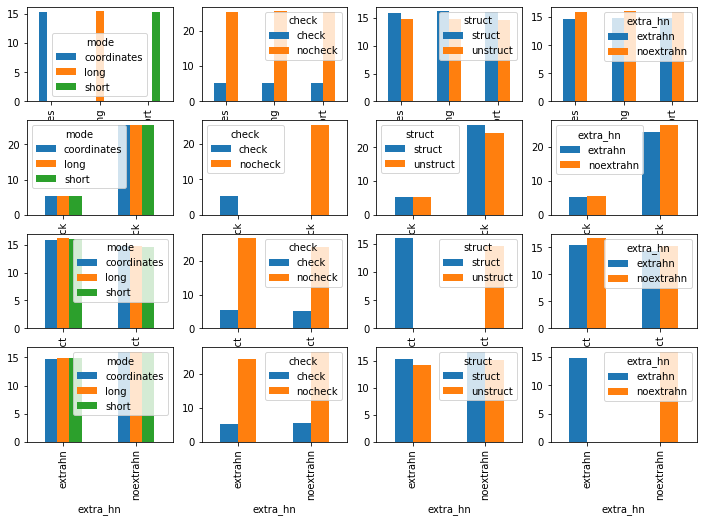

In [215]:
f, ax = plt.subplots(4,4, figsize=(12,8))
for i, fld1 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    for j, fld2 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):

        it_per_seconds.groupby([fld1, fld2]).it_per_sec.mean().unstack().plot.bar(ax=ax[i][j])

In [216]:
# results

In [217]:
# batch
batch_results = {}
batch_it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    batch_results[(mode,  check_label, struct_label, extra_hn)] =  call_ws_batch(addresses,
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode)[0]

    batch_it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(batch_it_per_seconds))
print("Iterations per seconds (batch calls):")
batch_it_per_seconds = pd.DataFrame(batch_it_per_seconds)
batch_it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215


coordinates check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393


coordinates check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787


coordinates nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540


coordinates nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


short nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


long nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


Iterations per seconds (batch calls):


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,38.412601
1,coordinates,check,struct,noextrahn,38.526215
2,coordinates,check,unstruct,extrahn,32.635393
3,coordinates,check,unstruct,noextrahn,32.226994
4,coordinates,nocheck,struct,extrahn,50.024807
5,coordinates,nocheck,struct,noextrahn,49.887787
6,coordinates,nocheck,unstruct,extrahn,41.013540
7,coordinates,nocheck,unstruct,noextrahn,40.794338
8,short,check,struct,extrahn,34.851866
9,short,check,struct,noextrahn,37.498868


In [ ]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(batch_it_per_seconds.drop("it_per_sec", axis=1).columns):
    batch_it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second (batch)", ax=fl_ax[i])
plt.tight_layout()

In [ ]:
print("Match rate (without nostreet)")
mr=[]
for k1 in ["struct", "unstruct"]:
    for k2 in ["check", "nocheck"]:
        keys = [k for k in  batch_results.keys() if k1 in k and k2 in k]
        mr.append({"struct": k1, "check": k2, "match_rate": min([batch_results[k][batch_results[k][("metadata", "method")]!="nostreet" ].shape[0]/addresses.shape[0] for k in keys])})

mr = pd.DataFrame(mr).set_index(["struct","check" ]).unstack()

mr.plot.bar() 
mr